# Finally, the correct Gi* visualization

In [1]:
# Load packages 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns         
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
import pprint
from functools import reduce
from scipy.stats import zscore
from scipy import stats

# Remove max columns
pd.set_option('display.max_columns', None)

In [2]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))

/tmp/ipykernel_675872/815627485.py:6: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [3]:
comm_small = comm_v2[['Census tract 2010 ID', 'County Name', 'State/Territory', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged', 'Total population']]

comm_small = comm_small.rename(columns={
    'Census tract 2010 ID': 'tract_id',
    'County Name':'county',
    'State/Territory':'state',
    'Total threshold criteria exceeded':'total_criteria', 
    'Total categories exceeded':'total_burdens', 
    'Identified as disadvantaged':'dac', 
    'Total population':'total_population'
})

# geometry, GEOID10
geo_join = v2_geo[['GEOID10', 'geometry']].rename(columns={'GEOID10':'tract_id'})
geo_join['tract_id'] =geo_join['tract_id'].astype('int64')

# Merge with geodf
complete = pd.merge(comm_small, geo_join, how='left', on='tract_id')

# Reassert GDF
complete =gpd.GeoDataFrame(complete)

# Drop geometry NAs
complete = complete[(complete.geometry.type == 'Polygon') |( complete.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
complete.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [4]:
# LISA

# Create weights using Queen method 
w = lps.weights.Queen(complete['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(complete['total_burdens'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(complete['total_criteria'], w, transform='R', permutations=9999)

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [5]:
# Adding the CORRECT gi star and p value to the new data frame
results = complete.copy()
results['gis_sim_burd'] = gstar_burden.z_sim 
results['p_sim_burd'] = gstar_burden.p_sim 

# Add indicator stats
results['gis_sim_ind'] = gstar_crit.z_sim 
results['p_sim_ind'] = gstar_crit.p_sim 

In [6]:
results.head()

,tract_id,county,state,total_criteria,total_burdens,dac,total_population,geometry,gis_sim_burd,p_sim_burd,gis_sim_ind,p_sim_ind
0,1001020100,Autauga County,Alabama,0,0.0,False,1993.0,"POLYGON ((-86.48196 32.49876, -86.48189 32.498...",-1.244027,0.0001,-1.107778,0.0001
1,1001020200,Autauga County,Alabama,0,0.0,False,1959.0,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,...",-1.389272,0.0001,-1.239085,0.0001
2,1001020300,Autauga County,Alabama,0,0.0,False,3507.0,"POLYGON ((-86.46538 32.47372, -86.46597 32.473...",-1.244027,0.0001,-1.107778,0.0001
3,1001020400,Autauga County,Alabama,0,0.0,False,3878.0,"POLYGON ((-86.43807 32.45349, -86.43812 32.453...",-1.244027,0.0001,-1.107778,0.0001
4,1001020500,Autauga County,Alabama,0,0.0,False,10596.0,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369...",-1.244027,0.0001,-1.107778,0.0001


In [ ]:
# if results['gis_sim_burd'] < 0 :
#     results['p_sim_burd'] = -results['p_sim_burd']
# else:
#     results['p_sim_burd'] = results['p_sim_burd']

# Using .loc to apply the condition element-wise
results.loc[results['gis_sim_burd'] < 0, 'p_sim_burd'] = -results['p_sim_burd']
results.loc[results['gis_sim_burd'] >= 0, 'p_sim_burd'] = results['p_sim_burd']
# Don't know which row to set equal to 0. Becomes an issue later on with the color binning

results.loc[results['gis_sim_ind'] < 0, 'p_sim_ind'] = -results['p_sim_ind']
results.loc[results['gis_sim_ind'] >= 0, 'p_sim_ind'] = results['p_sim_ind']

In [10]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for ease of mapping
results_cont = results[results['state'].isin(state_names)]

I have no idea how to get the colors to do what we want them to do. Also not sure if the "turning the p-value negative" thing worked. Tempted to try to do it like geoda did where they have a whole separate row with the `0, 1, 2` identifier. 

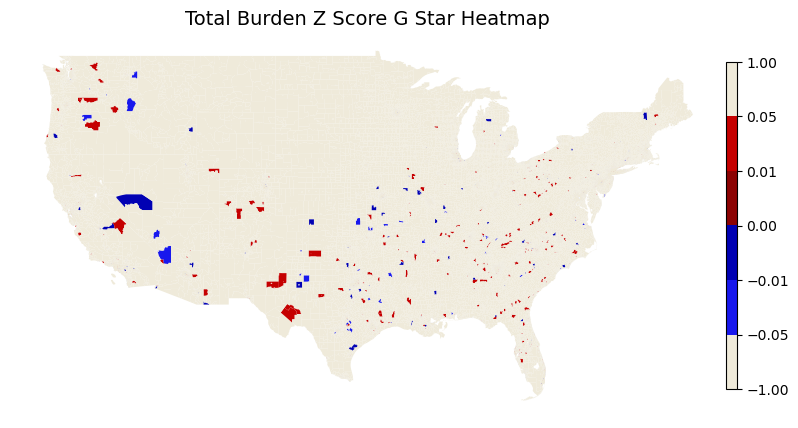

In [15]:
# Define 5 distinct colors
# colors = ["#0101b3", "#1818ed", "#efeada", "#c50000", "#8c0303"]  
colors = ["#efeada", "#1818ed", "#0101b3",  "#8c0303", "#c50000", "#efeada"]  

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
bounds = [-1, -0.05, -0.01, -1e-12, 0.01, 0.05, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(11,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Total Burden Z Score G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results_cont.plot(ax=ax,
                column='gis_sim_burd',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='vertical', pad=0, shrink=0.85, aspect=30)

# Modify the colorbar tick labels
# cbar.set_ticks([-2.78, -2.27, -1.8, 0, 1.8, 2.27, 2.78])
# cbar.set_ticklabels(['Cold Spot 99%', 'Cold Spot 95%', 'Not Significant', 'Hot Spot 95%', 'Hot Spot 99%']) 

plt.show()